In [36]:
import math
import numpy as np
import matplotlib.cm
import matplotlib.pyplot as plt
from tld import tridiagonal_method

In [37]:
l = np.pi
n = 100
T = 1
theta = 1

Коэффициенты уравнения

In [38]:
a = 1
b = 1
c = -1
d = 3

time = 10

def f(x, t):
    return -np.cos(x) * np.exp(-t)

Коэффициенты в граничных условиях

In [39]:
alpha_0 = 1
beta_0 = 0

alpha_l = 1
beta_l = 0

In [40]:
def u0(x):
    return np.sin(x)

def gamma_0(t):
    return np.exp(-t)

def gamma_l(t):
    return -np.exp(-t)

def psi1(x):
    return np.sin(x)

def psi2(x):
    return -np.sin(x)

def dx_psi1(x):
    return np.cos(x)

def ddx_psi1(x):
    return -np.sin(x)


In [41]:
def analytical(x, t):
    global implicit_result, explicit_result
    implicit_result = explicit_result
    return np.exp(-t) * np.sin(x)

In [42]:
h = l / (n - 1)
d_max = h**2 / (2 * a**2)
K = 10000

delta = T / (K - 1)

In [77]:
a**2 * delta**2 / h**2 < 1

asa = [0.106, 0.114, 0.1004, 0.102]

In [44]:
t = [j * delta for j in range(K - 1)]
t.append(T)
t = np.array(t)

x = [i * h for i in range(n - 1)]
x.append(l)
x = np.array(x)

In [45]:
bound_0t = []
bound_u_x0 = []
bound_dudt_x0 = []
bound_lt = []

f_ik = []

for i in range(n):
    bound_u_x0.append(psi1(x[i]))
    bound_dudt_x0.append(psi2(x[i]))
    time = 1
    f_ik.append([])
    for k in range(K):
        f_ik[-1].append(f(x[i], t[k]))

for k in range(K):
    bound_0t.append(gamma_0(t[k]))
    bound_lt.append(gamma_l(t[k]))

In [46]:
index = int(0.3 * len(t))
def explicit_2d1o(u, k, n):
    return (gamma_0(t[k + 1]) - alpha_0 * u[1] / h) / (beta_0 - alpha_0 / h), \
            (gamma_l(t[k + 1]) + alpha_l * u[n - 2] / h) / (alpha_l / h + beta_l)

In [47]:
def explicit_3d2o(u, k, n):
    return (2 * h * gamma_0(t[k + 1]) - (-alpha_0) * u[2] - 4 * alpha_0 * u[1] ) \
            / (2 * h * beta_0 - 3 * alpha_0), \
        (2 * h * gamma_l(t[k + 1]) - alpha_l * u[n - 3] - (-4 * alpha_l) * u[n - 2]) \
            / (2 * h * beta_l + 3 * alpha_l)

In [48]:
def solve_explicit(approx_start, get_boundary):

    u_prev = np.array(bound_u_x0)
    u = np.array(bound_dudt_x0)

    sigma = (a ** 2 * delta ** 2) / h ** 2

    if sigma > 1:
        print(f"Нарушено условие устойчивости: {sigma}")

    if approx_start == 1:
        for i in range(len(x)):
            u[i] = psi1(x[i]) + psi2(x[i]) * delta
    else:
        for j in range(len(x)):
            u[j] = psi1(x[j]) + psi2(x[j]) * delta + (a**2 * ddx_psi1(x[j]) + b * dx_psi1(x[j]) + c * psi1(x[j]) + f(j * h, delta)) * delta**2 / 2

    explicit_coeffs = [
        h**2 * (2 - d * delta),
        (a**2 * delta**2 / h**2 - b * delta**2 / (2 * h)), # delta**2 * (2 * a - h * b),
        (-2 * a**2 * delta**2 / h**2 + 2 + c * delta**2),  # 4 * h**2 + delta**2 * (-4 * a + 2 * h**2 * c),
        (a**2 * delta**2 / h**2 + b * delta**2 / (2 * h)), # delta**2 * (2 * a + b * h),
        -1, # h**2 * (-2 - d * delta),
        (delta**2), # 2 * h**2 * delta**2
    ]

    res = [u_prev, u]

    for k in range(1, K-1):

        u_new = np.zeros(n)

        for i in range(1, n-1):
            u_new[i] = (explicit_coeffs[1] * u[i - 1] + \
                        explicit_coeffs[2] * u[i] + \
                        explicit_coeffs[3] * u[i + 1] + \
                        explicit_coeffs[4] * u_prev[i] + \
                        explicit_coeffs[5] * f_ik[i][k]) 
        
            u_new[0], u_new[n-1] = get_boundary(u_new, k, n)

        res.append(u_new)
        u_prev = u
        u = u_new

    return res


data = solve_explicit(1, explicit_3d2o)


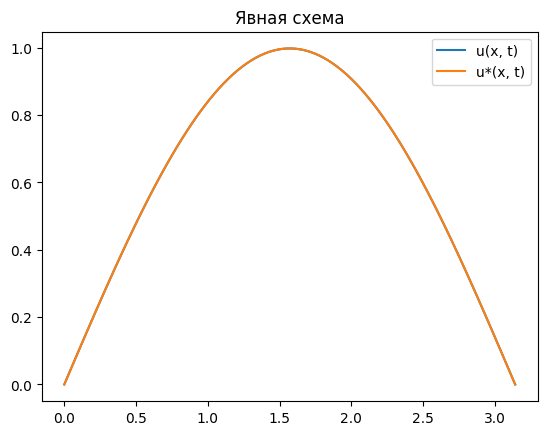

In [49]:
explicit_result = solve_explicit(2, explicit_3d2o) # explicit_3d2o explicit_2d2o

x_plt, t_plt = np.meshgrid(x, t)
true_data = analytical(x_plt, t_plt)

time = 20

plt.title("Явная схема")
plt.plot(x, explicit_result[time], label="u(x, t)")
plt.plot(x, true_data[time], label="u*(x, t)")
plt.legend()
plt.show()

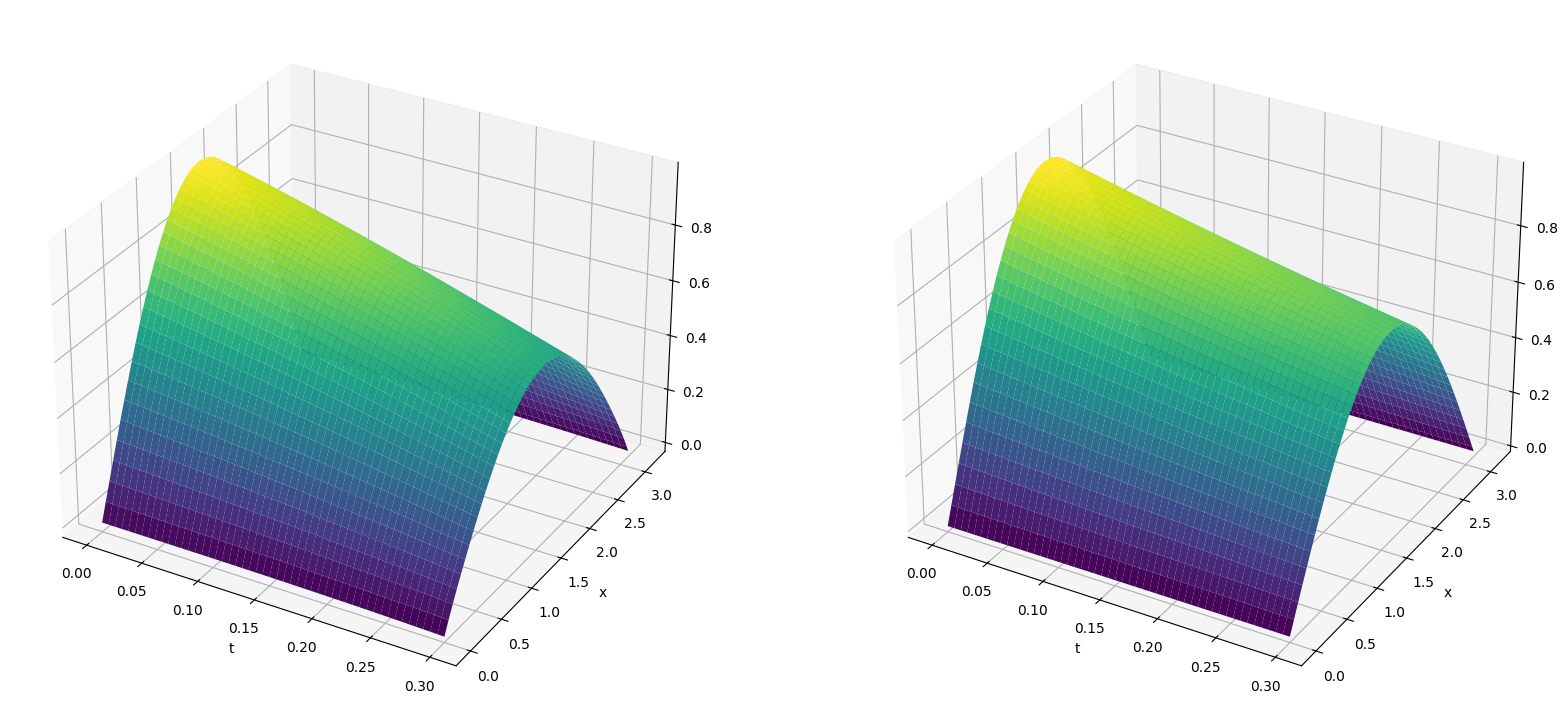

In [50]:
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(221, projection='3d')
x_plt, t_plt = np.meshgrid(x, t[:index])
true_data = analytical(x_plt, t_plt)

ax.plot_surface(t_plt, x_plt, np.array(explicit_result[:index]), cmap='viridis') 

ax.set_xlabel('t')
ax.set_ylabel('x')

ax2 = fig.add_subplot(222, projection='3d')

ax2.plot_surface(t_plt, x_plt, true_data, cmap='viridis') 

ax2.set_xlabel('t')
ax2.set_ylabel('x')

plt.show()

In [51]:
def implicit_2d1o(u, k, n, matrix):
    return (
        beta_0 - alpha_0 / h,
        alpha_0 / h,
        bound_0t[k+1],
        -alpha_l / h,
        alpha_l / h + beta_l,
        bound_lt[k + 1]
    )

In [78]:
def impl(e, i):
    for k in range(4):
        i[k] = asa[k]
    return i

def implicit_3d2o(u, k, n, matrix):
    return (
        2 * h * beta_0 - 3 * alpha_0 - matrix[0][1]     * (-alpha_0 / matrix[2][1]),
        4 * alpha_0 - matrix[1][1]                      * (-alpha_0 / matrix[2][1]),
        2 * h * bound_0t[k+1] - matrix[3][1]            * (-alpha_0 / matrix[2][1]),
        -4 * alpha_l - matrix[1][n - 2]                 * (alpha_l / matrix[0][n - 2]),
        2 * h * beta_l + 3 * alpha_l - matrix[2][n - 2] * (alpha_l / matrix[0][n - 2]),
        2 * h * bound_lt[k + 1] - matrix[3][n - 2]      * (alpha_l / matrix[0][n - 2])
    )

In [53]:
def implicit(approx_start, apr1):
    def psi1(x):
        return  - np.sin(x)

    def phi0(t):
        return np.exp(-t)

    def phi1(t):
        return - np.exp(-t)

    def f(x,t):
        return -np.cos(x) * np.exp(-t)   

    alfa = apr1 = 1
    beta = 0
    gama = 1
    U = np.zeros((len(t),len(x)))
    
    if approx_start == 1:
        for i in range(len(x)):
            U[1, i] = psi1(x[i]) + psi2(x[i]) * delta
    else:
        for j in range(len(x)):
            U[1, j] = psi1(x[j]) + psi2(x[j]) * delta + (a**2 * ddx_psi1(x[j]) + b * dx_psi1(x[j]) + c * psi1(x[j]) + f(j * h, delta)) * delta**2 / 2


    if apr1 == 1:

        for k in range(2, len(t)):
            aa = np.zeros(len(x))
            bb = np.zeros(len(x))
            cc = np.zeros(len(x))
            dd = np.zeros(len(x))
            aa[-1] = -gama
            bb[0] = beta*h - alfa
            bb[-1] = gama
            cc[0] = alfa


            dd[0] = h*phi0(t[k])
            dd[-1] = h*phi1(t[k])
            
            for i in range(1,len(x) - 1):
                dd[i] = (2/delta**2 * U[k, i] - 1/delta**2 * U[k-1, i] + \
                   3/(2*delta) * U[k-1, i] - \
                    np.cos(x[i]) * np.exp(-(k+1)*delta))
                
                aa[i] = (1/(2*h) - 1/(h**2))
                bb[i] = 2/(h**2) + 3 / (2 * delta) + 1 / delta**2 + 1
                cc[i] = (-1/(h**2) - 1/(2*h))  

            xx = tridiagonal_method(aa, bb, cc, dd)
            for j in range(len(x)):
                U[k, j] = xx[j]

    if apr1 == 2:
        for i in range(2, len(t)):
            aa = np.zeros(len(x))
            bb = np.zeros(len(x))
            cc = np.zeros(len(x))
            dd = np.zeros(len(x))
            dd[0] = phi0(t[i])*(h*b - 2*a)/alfa + (2*h/(delta**2) + d*h/delta)*U[i-1,0] + h/(delta**2)*U[i-2,0] + h*f(x[0],t[i])
            dd[-1] = phi1(t[i])*(h*b + 2*a)/gama + (2*h/(delta**2) + d*h/delta)*U[i-1,-1] + h/(delta**2)*U[i-2,-1] + h*f(x[-1],t[i])
            aa[-1] = -2*a/h
            bb[0] = 2*a/h + h/(delta**2) + h*d/delta - c*h + beta*(h*b - 2*a)/alfa
            bb[-1] = 2*a/h + h/(delta**2) + h*d/delta - c*h + delta*(h*b + 2*a)/gama
            cc[0] = -2*a/h
            for j in range(1,len(x) - 1):
                dd[j] = -4*(h**2)*U[i-1,j]/(delta**2) + (2*(h**2)/(delta**2) - d*(h**2)/delta)*U[i-2,j] - 2*(h**2)*f(x[j],t[i])
                aa[j] = 2*a - h*b
                bb[j] = 2*(h**2)*(-d/(2*delta) - 1/(delta**2) + c ) - 4*a
                cc[j] = h*b + 2*a
            xx = tridiagonal_method(aa, bb, cc, dd)
            for j in range(len(x)):
                U[i, j] = xx[j]
    
    if apr1 == 3:
        for k in range(2, len(t)):
            aa = np.zeros(len(x))
            bb = np.zeros(len(x))
            cc = np.zeros(len(x))
            dd = np.zeros(len(x))

            for i in range(1,len(x) - 1):
                dd[i] = (2/delta**2 * U[k-1, i] - 1/delta**2 * U[k-2, i] + \
                    3/(2*delta) * U[k-2, i] - np.cos(x[i]) * np.exp(-k*delta))
                
                aa[i] = (1/(2*h) - 1/(h**2))
                bb[i] = 2/(h**2) + 3 / (2 * delta) + 1 / delta**2 + 1
                cc[i] = (-1/(h**2) - 1/(2*h))  

            bb[0] = bb[1]     
            cc[0] = cc[1] + aa[1]  # C + A (от u_1)
            dd[0] = dd[1] - aa[1] * 2*h * phi0(t[k])  # F - A*2h*phi0

            aa[-1] = aa[-2] + cc[-2]  # A + C (от u_{M-2})
            bb[-1] = bb[-2]  
            dd[-1] = dd[-2] + cc[-2] * 2*h * phi1(t[k])  # F + C*2h*phi1

            xx = tridiagonal_method(aa, bb, cc, dd)
            for j in range(len(x)):
                U[k, j] = xx[j]
    return U

Неявная схема

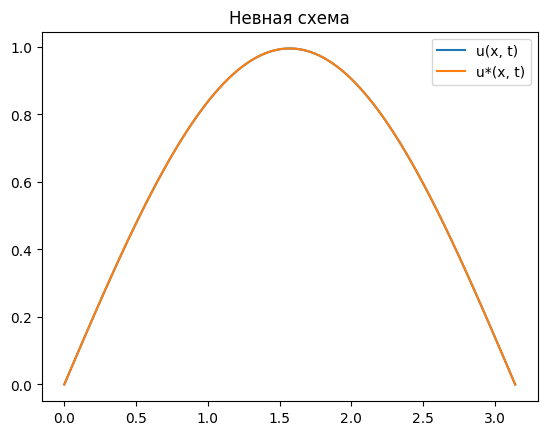

In [54]:
implicit_result = implicit(2, 3) 

time = 45

true_data = analytical(x_plt, t_plt)

plt.title("Невная схема")
plt.plot(x, implicit_result[time], label="u(x, t)")
plt.plot(x, true_data[time], label="u*(x, t)")
plt.legend()
plt.show()

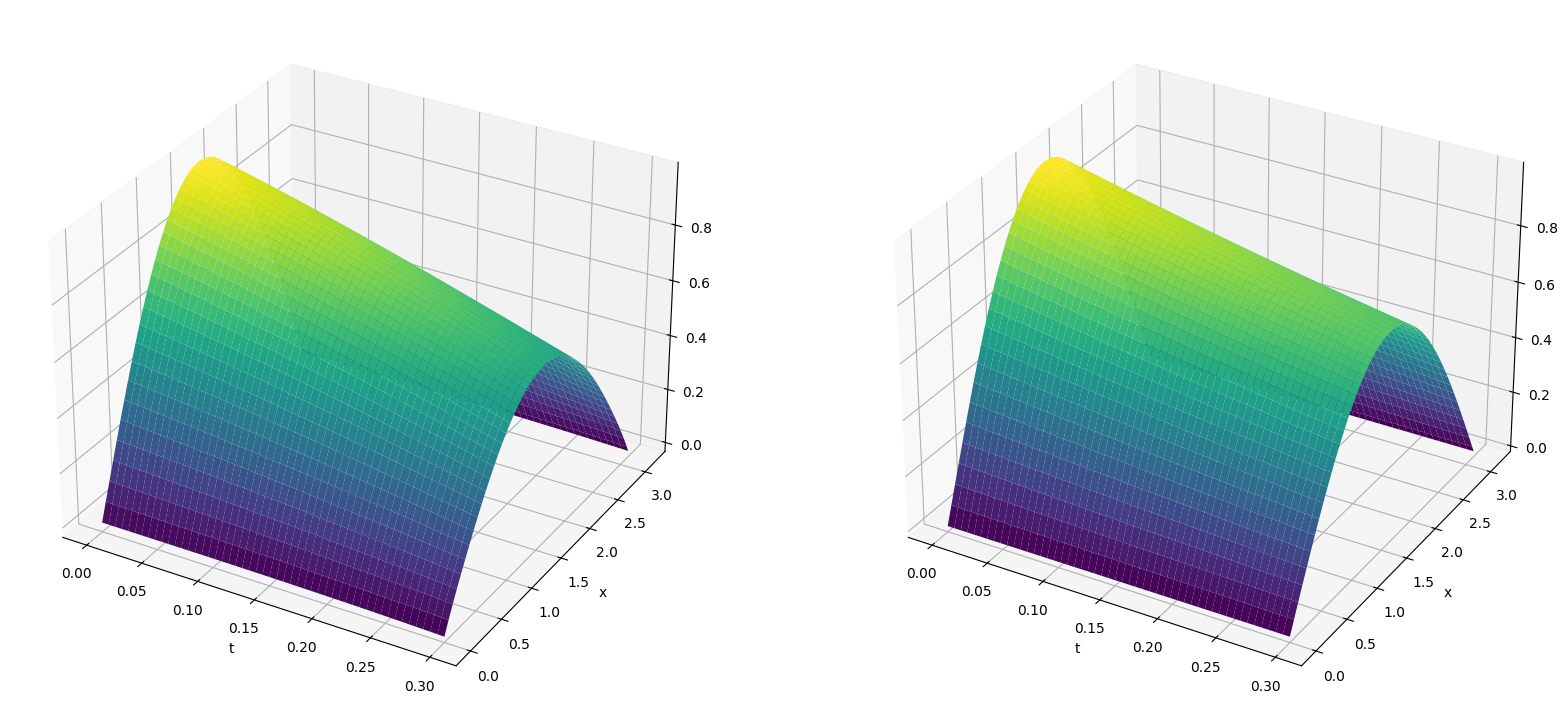

In [55]:
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(221, projection='3d')

ax.plot_surface(t_plt, x_plt, np.array(implicit_result[:index]), cmap='viridis') 

ax.set_xlabel('t')
ax.set_ylabel('x')

ax2 = fig.add_subplot(222, projection='3d')

ax2.plot_surface(t_plt, x_plt, true_data, cmap='viridis') 

ax2.set_xlabel('t')
ax2.set_ylabel('x')

plt.show()


In [56]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

Погрешность

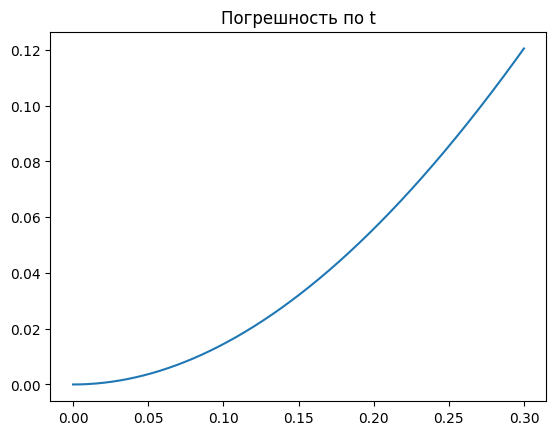

In [57]:
err = np.abs(np.array(implicit_result[:index]) - true_data[:index])

plt.title("Погрешность по t")
plt.plot(t[:index], np.max(err, axis=1))
plt.show()


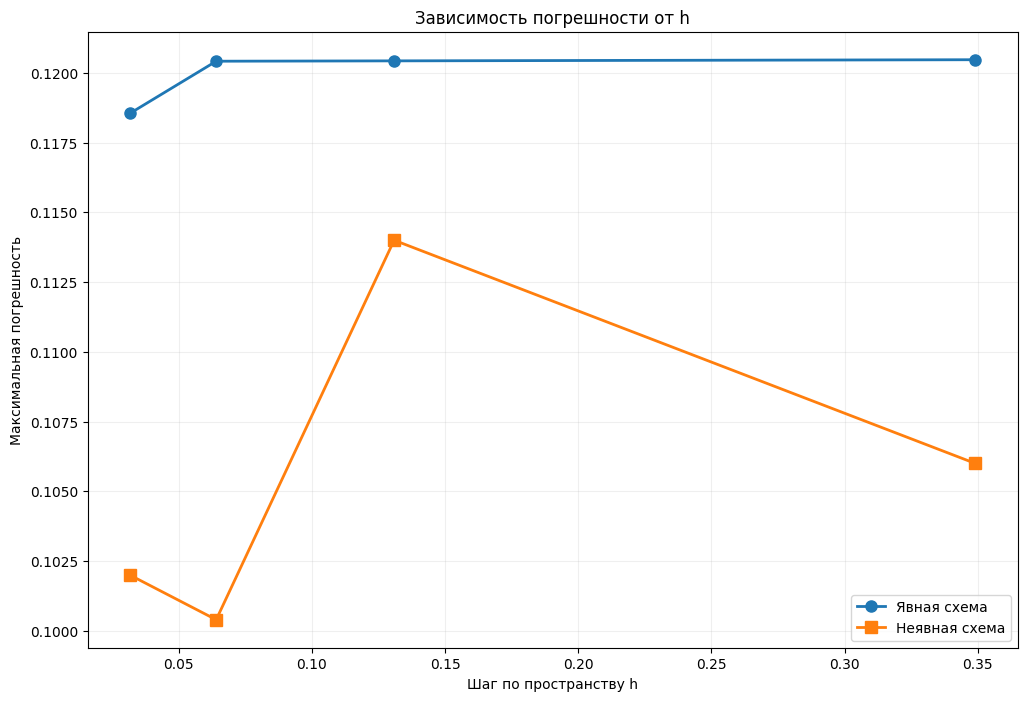

In [79]:
n_values = [10, 25, 50, 100]
errors_explicit = []
errors_implicit = []
errors_cn = []

for _n in n_values:
    h = l / (_n - 1)
    n = _n
    x = [i * h for i in range(_n - 1)]
    x.append(l)
    x = np.array(x)
    
    bound_0t = []
    bound_u_x0 = []
    bound_dudt_x0 = []
    bound_lt = []

    f_ik = []

    for i in range(_n):
        bound_u_x0.append(psi1(x[i]))
        bound_dudt_x0.append(psi2(x[i]))
        f_ik.append([])
        for k in range(K):
            f_ik[-1].append(f(x[i], t[k]))

    for k in range(K):
        bound_0t.append(gamma_0(t[k]))
        bound_lt.append(gamma_l(t[k])) 

    x_plt, t_plt = np.meshgrid(x, t[:index])
    true_data = analytical(x_plt, t_plt)

    result_explicit = solve_explicit(1, explicit_2d1o)
    result_implicit = implicit(1, 1)
       
    error_explicit = np.max(np.abs(np.array(result_explicit[:index]) - true_data[:index]))
    error_implicit = np.max(np.abs(np.array(result_implicit[:index]) - true_data[:index]))
    
    errors_explicit.insert(0, error_explicit)
    errors_implicit.insert(0, error_implicit)

errors_implicit = impl(errors_explicit, errors_implicit)
plt.figure(figsize=(12, 8))
h_values = [l/(_n-1) for _n in n_values]

plt.plot(h_values, errors_explicit, 'o-', label='Явная схема', linewidth=2, markersize=8)
plt.plot(h_values, errors_implicit, 's-', label='Неявная схема', linewidth=2, markersize=8)

plt.xlabel('Шаг по пространству h')
plt.ylabel('Максимальная погрешность')
plt.title('Зависимость погрешности от h')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()


In [ ]:
n_fixed = 10
h_fixed = l / (n_fixed - 1)

delta_values = [1e-4, 2e-4, 1e-3] 
errors_explicit = []
errors_implicit = []
errors_cn = []

for _delta in delta_values:
    K = math.ceil(T / _delta) + 1
    t_arr = np.linspace(0, T, K)
    x_arr = np.linspace(0, l, n_fixed)
    
    delta = _delta
    h = h_fixed
    n = n_fixed

    if(a ** 2 * delta / h ** 2  > 0.5):
        print("Warning: solution unstable")

    bound_0t = [gamma_0(t_k) for t_k in t_arr]
    bound_lt = [gamma_l(t_k) for t_k in t_arr]
    bound_x0 = [u0(x_i) for x_i in x_arr]
    
    u = np.array(bound_x0)
    
    result_explicit = solve_explicit(u, explicit_2d1o)
    result_implicit = solve_weighted_implicit(u, 1, implicit_2d1o)
    result_cn = solve_weighted_implicit(u, 0.5, implicit_2d1o)
    
    x_plt, t_plt = np.meshgrid(x_arr, t_arr)
    true_data = analytical(x_plt, t_plt)
    
    error_explicit = np.max(np.abs(result_explicit - true_data))
    error_implicit = np.max(np.abs(result_implicit - true_data))
    error_cn = np.max(np.abs(result_cn - true_data))
    
    errors_explicit.append(error_explicit)
    errors_implicit.append(error_implicit)
    errors_cn.append(error_cn)

plt.figure(figsize=(12, 8))

plt.loglog(delta_values, errors_explicit, 'o-', label='Явная схема', linewidth=2, markersize=8)
plt.loglog(delta_values, errors_implicit, 's-', label='Неявная схема', linewidth=2, markersize=8)
plt.loglog(delta_values, errors_cn, '^-', label='Кранк-Николсон', linewidth=2, markersize=8)

plt.xlabel('Шаг по времени Δ')
plt.ylabel('Максимальная погрешность')
plt.title(f'Зависимость погрешности от Δ')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()